# Outlier detection in python
There are many ways of detecting outliers, here we'll consider some advantages and disadvantages of different methods.

## method 1: extreme values
This is the simplest and most common version of outlier detection, which simply computes the standard deviation from a sample and highlights values above e.g. 3 stds as outliers. 

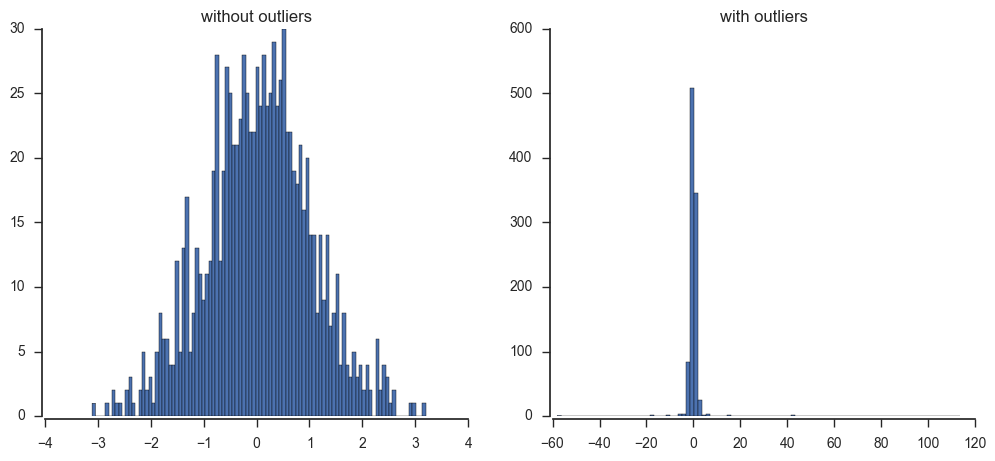

In [3]:
import numpy as np
from matplotlib import pyplot as pl
import seaborn as sn
sn.set_style('ticks')
%matplotlib inline

n_samples = 1000
n_outliers = 50
# let's create some gaussian random data
x = np.random.randn(n_samples)
# first, let make a histogram of the data:
f=pl.figure(figsize=(12,5))
f.add_subplot(121)
pl.title('without outliers')
pl.hist(x,100);
sn.despine(offset=2)

# and add some outliers
close_outliers = np.random.randint(0,n_samples,int(n_outliers/3))
x[close_outliers] *= 5
medium_outliers = np.random.randint(0,n_samples,int(n_outliers/3))
x[medium_outliers] *= 10
far_outliers = np.random.randint(0,n_samples,int(n_outliers/3))
x[far_outliers] *= 50

f.add_subplot(122)
pl.title('with outliers')
pl.hist(x,100);
sn.despine(offset=2)



The above clearly shows some extreme outliers, so let's add 3 stds lines to the plot

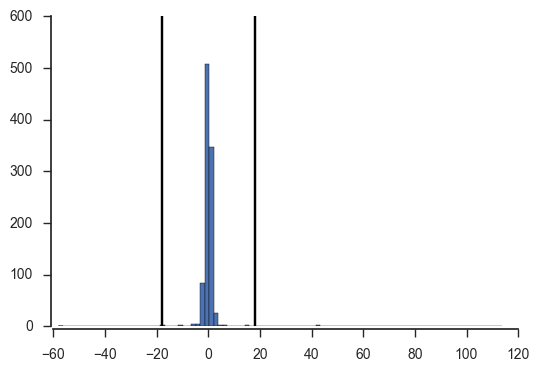

In [4]:
pl.hist(x,100);
pl.axvline(np.std(x)*3,color='k');
pl.axvline(-np.std(x)*3,color='k');
sn.despine(offset=2)


Let's see what happens when we do away with the values that are more than 3 stds away from the mean

close outliers detected: 1/16
medium outliers detected: 3/16
far outliers detected: 11/16


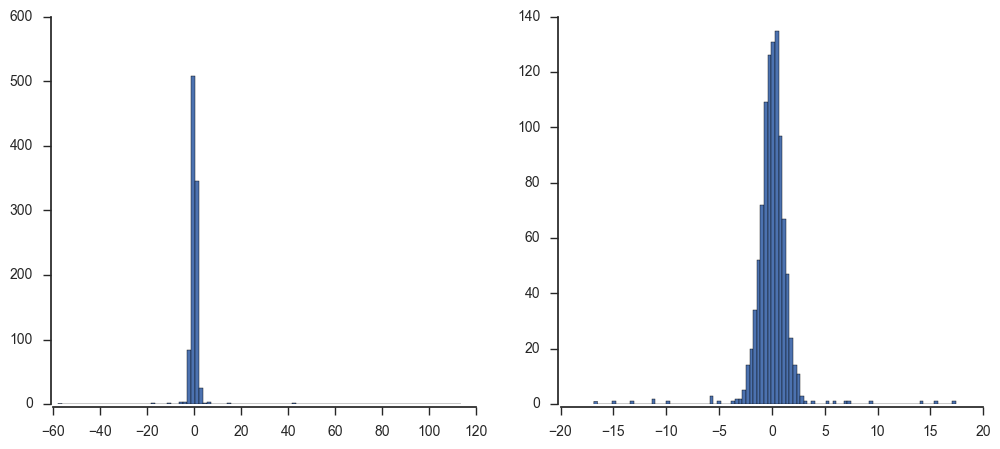

In [5]:
# calculate inliers based on extreme values
x_mean = np.mean(x)
x_std = np.std(x)
inliers = (x > (x_mean-x_std*3))*(x < (x_mean+x_std*3))
valid_x = x[inliers]

f=pl.figure(figsize=(12,5))
f.add_subplot(121)
pl.hist(x,100);
sn.despine(offset=2)

f.add_subplot(122)
pl.hist(x[inliers],100);
sn.despine(offset=2)
print 'close outliers detected: %d/%d'%(np.sum([ol in np.array(np.where(inliers==False)[0]) for ol in close_outliers]),len(close_outliers))
print 'medium outliers detected: %d/%d'%(np.sum([ol in np.array(np.where(inliers==False)[0]) for ol in medium_outliers]),len(medium_outliers))
print 'far outliers detected: %d/%d'%(np.sum([ol in np.array(np.where(inliers==False)[0]) for ol in far_outliers]),len(far_outliers))




So although the most extreme (far) outliers have now been correctly rejected, the 'close' and 'medium' outliers all remain. This approach could be done iteratively, but how to know how many iterations of this to do?

## method 2: median absolute deviation

The main problem with the method above arises from the fact that the standard deviation is highly sensitive to outliers, hence the the low thresholds for outliers. The population standard deviation can also be estimated using the median absolute deviiation. 

In [6]:
# First, let's calculate the median of the distances to the median:
mad = np.median(np.abs(x-np.median(x)))
print mad

0.664455830206


In [7]:
# Then, let's express all the distances to the median in terms of the MAD 
# to find how many MADS each point is away from the median
dist_mad = np.abs(x-np.median(x))/mad

Now, what is a good cutoff MAD to remove outliers? Turns out that when you mutliply the MAD with a constant, the MAD is actually a good estimator for the population standard deviation. So if we do that, we can refer again to our 3 stds from the mean as in the method 1. For normally distributed data, this threshold is about 1.4826, but we can calculate it as $1/Q(75)$, in other words, the reciprocal of the 75th percentile. 

In [8]:
a = np.random.randn(100000)
k = 1/np.percentile(a,75)
print k

1.48396985609


Now we can flag outliers by setting the amount of corrected (3) MADs away from the median.

In [9]:
threshold = k*mad*3

In [10]:
# let's put the mad in a function:

def mad_inliers(data,n_mads=3):
    k=1/np.percentile(data-np.median(data),75)
    mad = np.median(np.abs(data-np.median(data)))

    threshold = k*mad*n_mads
    inliers = (np.abs(data-np.median(data))<threshold)

    return inliers

close outliers detected: 10/16
medium outliers detected: 14/16
far outliers detected: 15/16


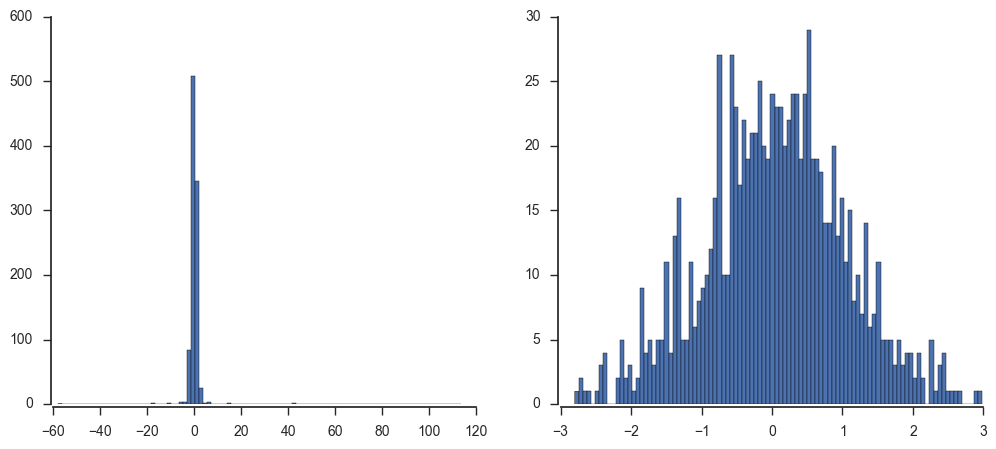

In [11]:
# and try it out
inliers = mad_inliers(x,3)

f=pl.figure(figsize=(12,5))
f.add_subplot(121)
pl.hist(x,100);
sn.despine(offset=2)

f.add_subplot(122)
pl.hist(x[inliers],100);
sn.despine(offset=2)
print 'close outliers detected: %d/%d'%(np.sum([ol in np.array(np.where(inliers==False)[0]) for ol in close_outliers]),len(close_outliers))
print 'medium outliers detected: %d/%d'%(np.sum([ol in np.array(np.where(inliers==False)[0]) for ol in medium_outliers]),len(medium_outliers))
print 'far outliers detected: %d/%d'%(np.sum([ol in np.array(np.where(inliers==False)[0]) for ol in far_outliers]),len(far_outliers))


This approach does a much better job, detecting many more close and medium outliers. However, this approach has one downside, as it assumes that the data is normally distributed. Let's see how it works for data that are skewed meaned

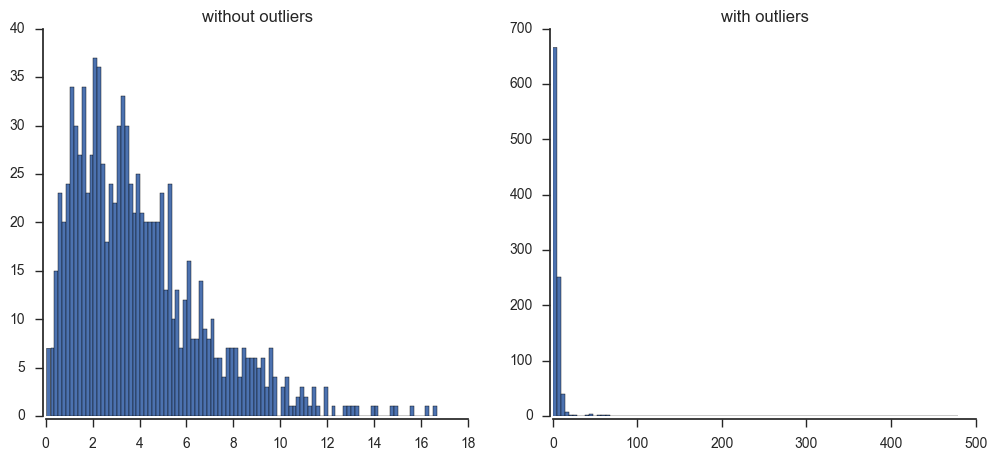

In [12]:
n_samples = 1000
n_outliers = 50
# let's create some gamma distributed random data
x = np.random.gamma(2,2,size=n_samples)

# first, let make a histogram of the data:
f=pl.figure(figsize=(12,5))
f.add_subplot(121)
pl.title('without outliers')
pl.hist(x,100);
sn.despine(offset=2)

# and add some outliers
close_outliers = np.random.randint(0,n_samples,int(n_outliers/3))
x[close_outliers] *= 5
medium_outliers = np.random.randint(0,n_samples,int(n_outliers/3))
x[medium_outliers] *= 10
far_outliers = np.random.randint(0,n_samples,int(n_outliers/3))
x[far_outliers] *= 50

f.add_subplot(122)
pl.title('with outliers')
pl.hist(x,100);
sn.despine(offset=2)

close outliers detected: 13/16
medium outliers detected: 16/16
far outliers detected: 16/16


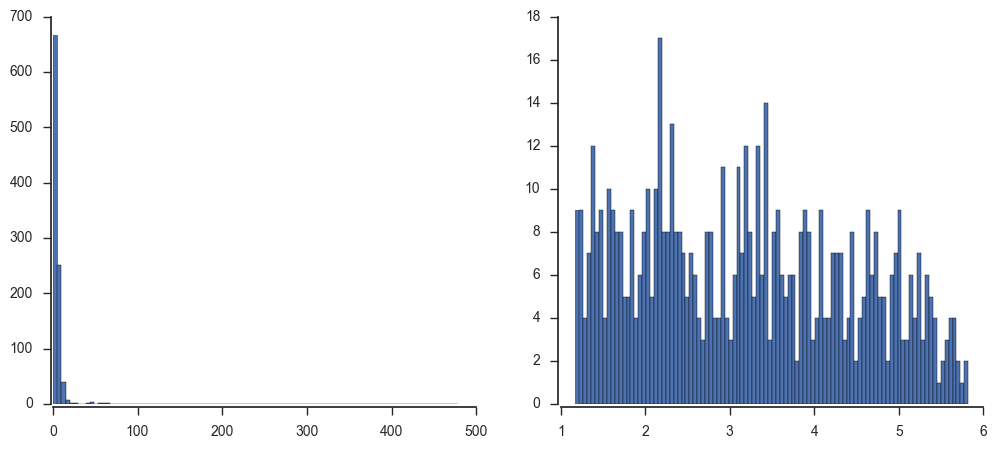

In [13]:
# and try it out
inliers = mad_inliers(x,3)

f=pl.figure(figsize=(12,5))
f.add_subplot(121)
pl.hist(x,100);
sn.despine(offset=2)

f.add_subplot(122)
pl.hist(x[inliers],100);
sn.despine(offset=2)
print 'close outliers detected: %d/%d'%(np.sum([ol in np.array(np.where(inliers==False)[0]) for ol in close_outliers]),len(close_outliers))
print 'medium outliers detected: %d/%d'%(np.sum([ol in np.array(np.where(inliers==False)[0]) for ol in medium_outliers]),len(medium_outliers))
print 'far outliers detected: %d/%d'%(np.sum([ol in np.array(np.where(inliers==False)[0]) for ol in far_outliers]),len(far_outliers))



So you can see that the outlier detection was way too conservative, doing away with many inlier values. There are two problems here. First is that the k value determination of 1/Q(75) only works for normally distributed data. Setting this value back to assuming normality solves one part of our problem.

In [14]:
def mad_inliers(data,n_mads=3):
    k=1.4826
    mad = np.median(np.abs(data-np.median(data)))

    threshold = k*mad*n_mads
    inliers = (np.abs(data-np.median(data))<threshold)

    return inliers

close outliers detected: 9/16
medium outliers detected: 15/16
far outliers detected: 16/16


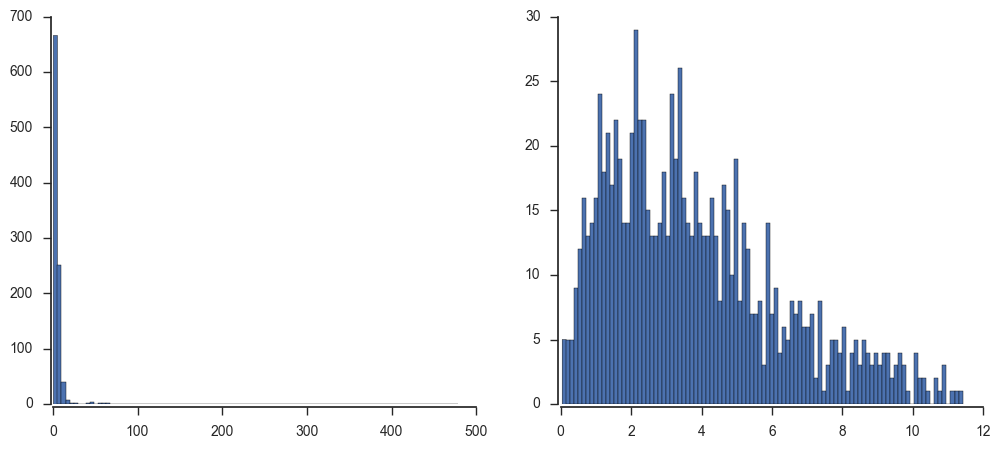

In [15]:
# and try it out
inliers = mad_inliers(x,3)

f=pl.figure(figsize=(12,5))
f.add_subplot(121)
pl.hist(x,100);
sn.despine(offset=2)

f.add_subplot(122)
pl.hist(x[inliers],100);
sn.despine(offset=2)
print 'close outliers detected: %d/%d'%(np.sum([ol in np.array(np.where(inliers==False)[0]) for ol in close_outliers]),len(close_outliers))
print 'medium outliers detected: %d/%d'%(np.sum([ol in np.array(np.where(inliers==False)[0]) for ol in medium_outliers]),len(medium_outliers))
print 'far outliers detected: %d/%d'%(np.sum([ol in np.array(np.where(inliers==False)[0]) for ol in far_outliers]),len(far_outliers))



This looks much more like our original distribution. However, we can still find that the long tail (the right side) has been cut off too short, as the original distribution contained values of up to 20. We can alleviate this a little by doing the MAD on two sides separately, so calculating a left and right MAD.

In [16]:
def mad_inliers_2_sided(data,n_mads=3):
    k = 1.4826
    mad_left = np.median(np.abs(data[data<np.median(data)]-np.median(data)))
    mad_right = np.median(np.abs(data[data>np.median(data)]-np.median(data)))

    left_threshold = 1.4826*mad_left*n_mads
    right_threshold = 1.4826*mad_right*n_mads

    left_inliers = (np.abs(data[data<np.median(data)]-np.median(data))<left_threshold)
    right_inliers = (np.abs(data[data>np.median(data)]-np.median(data))<right_threshold)

    inliers = np.ones_like(data).astype(bool)
    inliers[data<np.median(data)] = left_inliers
    inliers[data>np.median(data)] = right_inliers

    return inliers

close outliers detected: 8/16
medium outliers detected: 15/16
far outliers detected: 16/16


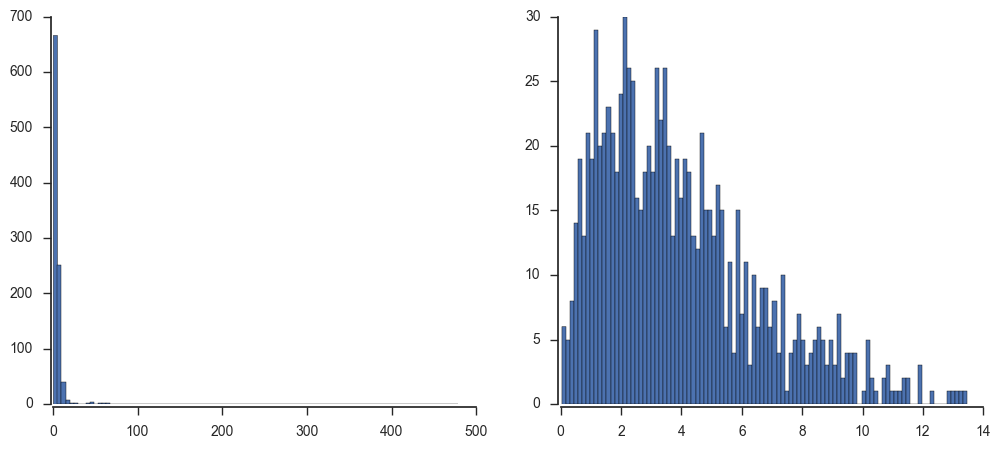

In [17]:
# and try it out
inliers = mad_inliers_2_sided(x,3)

f=pl.figure(figsize=(12,5))
f.add_subplot(121)
pl.hist(x,100);
sn.despine(offset=2)

f.add_subplot(122)
pl.hist(x[inliers],100);
sn.despine(offset=2)
print 'close outliers detected: %d/%d'%(np.sum([ol in np.array(np.where(inliers==False)[0]) for ol in close_outliers]),len(close_outliers))
print 'medium outliers detected: %d/%d'%(np.sum([ol in np.array(np.where(inliers==False)[0]) for ol in medium_outliers]),len(medium_outliers))
print 'far outliers detected: %d/%d'%(np.sum([ol in np.array(np.where(inliers==False)[0]) for ol in far_outliers]),len(far_outliers))




This made the right tail somewhat more liberal, extending to values up to 14 now. 